# Semantic segmentation with backbone

In [1]:
!pip install segmentation-models --quiet
!pip install mycolorpy --quiet
!pip install tensorflow-addons --quiet
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/M_DV_V2022

     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 1.1 MB 14.8 MB/s 
Mounted at /content/gdrive
/content/gdrive/MyDrive/M_DV_V2022


In [2]:
from unet_detection.models.vanilla_unet import vanilla_unet

In [3]:
from tensorflow import keras
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
import matplotlib.pyplot as plt
import numpy as np
from cv2 import Sobel, Laplacian, watershed
import cv2 as cv
import seaborn as sns

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mycolorpy import colorlist as mcp


#from PIL import Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input
from keras.callbacks import EarlyStopping
import tensorflow_addons as tfa

from keras.layers import Input, Conv2D
from keras.models import Model


import tensorflow as tf
from tensorflow.keras import backend as K

# Load data

In [6]:
X_train = np.load("data/spec_lib/X_data.npy") 
y_train = np.load("data/spec_lib/y_data.npy")

X_val = np.load("data/spec_lib/X_data_val.npy")
y_val = np.load("data/spec_lib/y_data_val.npy")

X_test = np.load("data/spec_lib/X_data_test.npy")
y_test = np.load("data/spec_lib/y_data_test.npy")

In [7]:
def redesign_y(y):
  n,r1,c1,d = y.shape
  # Adds a new dimension of layer too have two class problem.
  yy = np.append(y, np.zeros((n, r1, c1,d)), axis=3)
  for i in range(int(y.max()-1)):  
    yy = np.append(yy, np.zeros((n, r1, c1,d)), axis=3)
  #yy[yy >= 0.001] = 1
  yy1 = yy.copy()
  yy1[:,:,:,0] = 0 # reset map
  for i in range(n):
    values = yy[i,:,:,0]
    for r in range(r1):
      for c in range(c1):
        value = yy[i,r,c,0]
        yy1[i,r,c,int(value)] = 1

  return yy1

In [8]:
y_test = y_test.reshape((y_test.shape[0],y_test.shape[1], y_test.shape[2], 1))

In [9]:
y_train = redesign_y(y_train)
y_val = redesign_y(y_val)
y_test = redesign_y(y_test)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150, 128, 128, 11)
(20, 128, 128, 11)
(24, 128, 128, 11)


# Set up metrics/loss

In [14]:
def multi_mcc_loss(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return 1 - K.mean(mcc)

def multi_mcc(y_true, y_pred, false_pos_penal=1.0):
    # Reshape image to flatten form
    y_true = K.reshape(y_true, [-1, y_true.shape[-1]])
    y_pred = K.reshape(y_pred, [-1, y_pred.shape[-1]])

    confusion_m = tf.matmul(K.transpose(y_true), y_pred)
    if false_pos_penal != 1.0:
      """
      This part is done for penalization of FalsePos symmetrically with FalseNeg,
      i.e. FalseNeg is favorized for the same factor. In such way MCC values are comparable.
      If you want to penalize FalseNeg, than just set false_pos_penal < 1.0 ;)
      """
      confusion_m = tf.linalg.band_part(confusion_m, 0, 0) + tf.linalg.band_part(confusion_m, 0, -1)*false_pos_penal + tf.linalg.band_part(confusion_m, -1, 0)/false_pos_penal
    
    N = K.sum(confusion_m)
    
    up = N*tf.linalg.trace(confusion_m) - K.sum(tf.matmul(confusion_m, confusion_m))
    down_left = K.sqrt(N**2 - K.sum(tf.matmul(confusion_m, K.transpose(confusion_m))))
    down_right = K.sqrt(N**2 - K.sum(tf.matmul(K.transpose(confusion_m), confusion_m)))
    
    mcc = up / (down_left * down_right + K.epsilon())
    mcc = tf.where(tf.math.is_nan(mcc), tf.zeros_like(mcc), mcc)
    
    return K.mean(mcc)


# Set up model

In [15]:
#base_model = sm.Unet(backbone_name='resnet34', encoder_weights='imagenet',
#                     classes=11, activation='softmax', encoder_freeze=True)

#inp = Input(shape=(128, 128, 399))
#l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
#out = base_model(l1)

#model = Model(inp, out, name=base_model.name)

model = sm.Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(128, 128, 399),
                classes=11, activation='softmax')

In [16]:
from segmentation_models.losses import CategoricalFocalLoss

loss = CategoricalFocalLoss(gamma=1.5)

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1, multi_mcc])

In [ ]:
h = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=150)

Epoch 1/150
5/5 [==============================] - 21s 2s/step - loss: 0.0372 - f1_score: 0.3083 - multi_mcc: 0.0123 - val_loss: 0.1568 - val_f1_score: 0.5719 - val_multi_mcc: -0.0071
Epoch 2/150
5/5 [==============================] - 4s 751ms/step - loss: 0.0232 - f1_score: 0.7573 - multi_mcc: 0.0358 - val_loss: 0.0907 - val_f1_score: 0.7525 - val_multi_mcc: 3.8281e-04
Epoch 3/150
5/5 [==============================] - 4s 754ms/step - loss: 0.0155 - f1_score: 0.8425 - multi_mcc: 0.0641 - val_loss: 0.0895 - val_f1_score: 0.7557 - val_multi_mcc: 0.0025
Epoch 4/150
5/5 [==============================] - 4s 755ms/step - loss: 0.0114 - f1_score: 0.8541 - multi_mcc: 0.0897 - val_loss: 0.0689 - val_f1_score: 0.8119 - val_multi_mcc: 0.0037
Epoch 5/150
5/5 [==============================] - 4s 754ms/step - loss: 0.0094 - f1_score: 0.8638 - multi_mcc: 0.1278 - val_loss: 0.0667 - val_f1_score: 0.8179 - val_multi_mcc: 0.0016
Epoch 6/150
5/5 [==============================] - 4s 752ms/step - loss:

Text(0.5, 1.0, 'scorings')

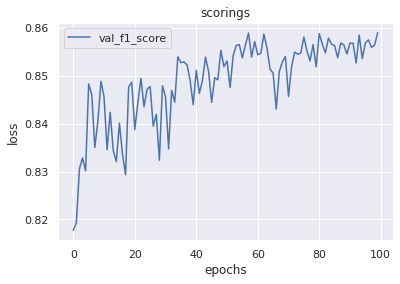

In [20]:
sns.set_theme()
sns.lineplot(data={key:(h.history[key][50:]) for key in ['val_f1_score']})
plt.xlabel("epochs"); plt.ylabel("loss")
plt.title("scorings")

In [10]:
from keras.layers import Input
u = vanilla_unet()

img1 = Input(shape=(128,128,399))

model = u.get_unet(img1, None, n_classes=11, last_activation='softmax')

from segmentation_models.losses import CategoricalFocalLoss

loss = CategoricalFocalLoss()

f1 = tfa.metrics.F1Score(num_classes=11, average='micro')
model.compile(optimizer='adam',
                loss=loss,
                metrics=[f1])

In [11]:
h = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=150)

Epoch 1/150
5/5 [==============================] - 24s 1s/step - loss: 0.0572 - f1_score: 0.0264 - val_loss: 0.3309 - val_f1_score: 0.0192
Epoch 2/150
5/5 [==============================] - 2s 459ms/step - loss: 0.0469 - f1_score: 0.1309 - val_loss: 0.3581 - val_f1_score: 0.0195
Epoch 3/150
5/5 [==============================] - 2s 425ms/step - loss: 0.0397 - f1_score: 0.3926 - val_loss: 0.3584 - val_f1_score: 0.0205
Epoch 4/150
5/5 [==============================] - 2s 425ms/step - loss: 0.0348 - f1_score: 0.5463 - val_loss: 0.3582 - val_f1_score: 0.0209
Epoch 5/150
5/5 [==============================] - 2s 423ms/step - loss: 0.0311 - f1_score: 0.6061 - val_loss: 0.3567 - val_f1_score: 0.0217
Epoch 6/150
5/5 [==============================] - 2s 418ms/step - loss: 0.0285 - f1_score: 0.6318 - val_loss: 0.3456 - val_f1_score: 0.0212
Epoch 7/150
5/5 [==============================] - 2s 416ms/step - loss: 0.0268 - f1_score: 0.6504 - val_loss: 0.3431 - val_f1_score: 0.0234
Epoch 8/150
5/5

# Show pred data

In [12]:
rød = X_test[:,:,:,81]; grønn = X_test[:,:,:,46]; blå = X_test[:,:,:,21];
rgb = [np.dstack((r,g,b)) for r,g,b in zip(rød,grønn,blå)]
rgb = np.array(rgb)

nx = 6
ny = 4

def arange_image(img):
  u = []
  o = 0
  for i in range(int(nx)):
    b = np.array(img[o])
    o += 1
    for j in range(1,int(ny)):
      b = np.append(b, img[o], axis=1)
      o += 1
                  
    if len(u) == 0:
      u = b
    else:
      u = np.append(u, b, axis=0)
  return u


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Prediciton')

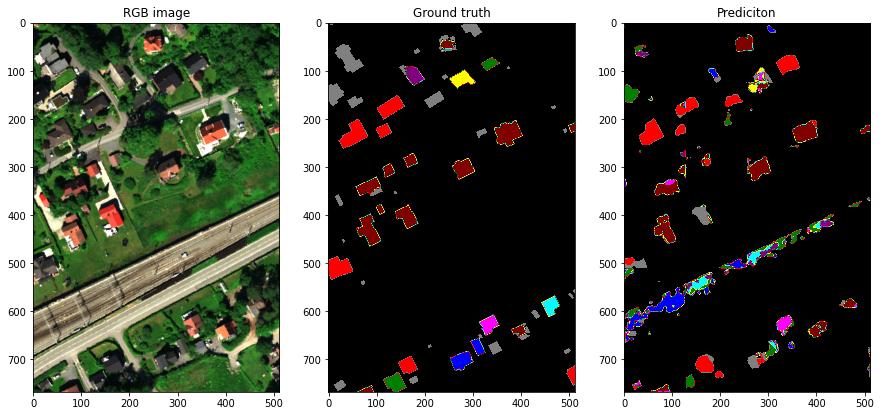

In [13]:
classes = ["None", "unknown", "black concrete", "metal roofing", "black ceramic", "brown concrete", 
           "red concrete", "gravel", "green ceramic", "pcv", "tar roofing paper"]

colormap = ListedColormap(["black", "gray", "red", "green", "yellow", "cyan", "maroon",
                           "magenta", "seagreen", "purple", "blue"])

y = y_test.argmax(axis=3)
pred = model.predict(X_test)
p = np.argmax(pred,axis=3)

u = arange_image(rgb)
v = arange_image(y)
w = arange_image(p)

w[0:11, 0] = [0,1,2,3,4,5,6,7,8,9,10]

sns.reset_orig()
fig, (ax0, ax1,ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
im1 = ax0.imshow(u/2500); ax0.set_title("RGB image")
im1 = ax1.imshow(v, cmap=colormap); ax1.set_title("Ground truth")
im1 = ax2.imshow(w, cmap=colormap); ax2.set_title("Prediciton")
